# Chime Case Study
Ravi Dayabhai

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [12]:
# Import dependencies
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import sem, beta, binom
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Global variables

# Revenue
INTERCHANGE_RATE = 1.5 / 100 # per purchase dollar

# Costs
COGS = 1.05 / 100 # per purchase dollar
SPEND_TRACKER_PMPM = 5 # cost per member-month

## Data Load / Processing

Luckily, these data are super clean and relatively small. Conversion to CSVs ensured data type integrity and these toy data contain no nulls.

In [4]:
# Load data
DATA_PATH = "../data/"
data_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))
data_dict = {}
for file in data_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    df_i = pd.read_csv(file)
    data_dict[file_name] = df_i

# Assign to user-friendly variables
df_perf = data_dict['performance'].copy()
df_acq_segment = data_dict['acquisition_segment_counts'].copy()
df_acq_agg = data_dict['acquisition_agg'].copy()

# Set indices
df_acq_agg.set_index('Variant', inplace=True)
df_acq_segment.set_index('Variant', inplace=True)
df_perf.set_index(['Months Since Conversion', 'Test Group', 'Segment'], 
                  inplace=True)

# Reorder rows for convenience in NHST
df_acq_agg = df_acq_agg.reindex(index=df_acq_agg.index[::-1])
df_acq_segment = df_acq_segment.reindex(index=df_acq_segment.index[::-1])

## EDA

The exploratory data analysis will largely be driven by the questions extracted from the case study prompt.

**Notes**:

- For the The _Treatment_, in this context, comprises a customer journey featuring a spend tracker, wherease the _Control_ arm is not availed of the existence of a spend tracker.
- Average monthly spend for Segment B is _higher_ than Segment A's.
- Members in Segment B are _more likely_ to have additional bank accounts in addition to Chime.
- The Spend Tracker is free _to all members_ and will cost Chime \$5 per member per month (PMPM), i.e., it is not revenue generating itself.

### Acquisition

- What does the funnel look like for Control vs. Treatment?
- Assuming cogent data collection, did the Treatment drive lift in CTR? Conversions?
- Segment A vs. Segment B: are the distributions of converted users different in each variant?
- How does overall CAC compare for Control vs. Treatment?

In [5]:
# Funnel metrics by variant
df_acq_agg['CTR'] = df_acq_agg['Unique Clicks'] / df_acq_agg['Population']
df_acq_agg['Click CR'] = df_acq_agg['Conversions'] / df_acq_agg['Unique Clicks']
df_acq_agg['User CR'] = df_acq_agg['CTR'] * df_acq_agg['Click CR']

# Cost-per-Unique-Click by variant
df_acq_agg['CPUC'] = df_acq_agg['Spend'] / df_acq_agg['Unique Clicks']

# Cost-per-Conversion by variant
df_acq_agg['CAC'] = df_acq_agg['Spend'] / df_acq_agg['Conversions']

df_acq_agg

,Spend,Population,Unique Clicks,Conversions,CTR,Click CR,User CR,CPUC,CAC
Variant,,,,,,,,,
Test,1020581,20214295,208206,23007,0.0103,0.110501,0.001138,4.901785,44.359586
Control,1010476,20014153,200140,19815,0.0100,0.099006,0.000990,5.048846,50.995508


#### Experimental Analysis: User Conversions

We'll start with a Frequentist's approach following the traditional null hypothesis signifance testing model.

We ultimately care about the conversion lift generated by advertising Chime's product _with_ the spend tracker vs. Control condition. Stated formally,

$$
H_{0}: p_{T} - p_{C} = 0\\
H_{a}: p_{T} - p_{C} > 0
$$

where $p_{T}$ and $p_{C}$ are the proportion of converted users in the Treatment and Control populations, respectively. The significance level, $\alpha$ for this test is set to $0.05$.


In [6]:
# Set significance level
alpha = 0.05

# Calculate test statistics, p-value for User CR
user_CR_test_stat, user_CR_p_value = proportions_ztest(
    count=df_acq_agg['Conversions'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"User Conversion Rate p-value: {user_CR_p_value}; statistically significant? {user_CR_p_value < alpha}")

# Calculate test statistics, p-value for CTR
CTR_test_stat, CTR_p_value = proportions_ztest(
    count=df_acq_agg['Unique Clicks'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"Click-thru-rate (CTR) p-value: {CTR_p_value}; statistically significant? {CTR_p_value < alpha}")

User Conversion Rate p-value: 2.460543238137127e-47; statistically significant? True
Click-thru-rate (CTR) p-value: 1.1368573134571388e-21; statistically significant? True


Both CTR and User CR are far below our significance level, indicating that the lift we're seeing is statistically significant. On a practical level, the c. 200 bps different in conversion rate is non-trivial (as we'll see when I turn my attention to the unit economics of the variants)!

#### Converted Users: Segment Distributions

I want to investigate whether the Treatment shifted the distribution of users (by segment) relative to Control. Let's visualize the segment distributions by variant:

In [10]:
# Break out data for standard errors, means
test_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Test', 'Segment A']),
                                      np.ones(df_acq_segment.loc['Test', 'Segment B'])), 
                                     axis=0)

control_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Control', 'Segment A']),
                                         np.ones(df_acq_segment.loc['Control', 'Segment B'])), 
                                        axis=0)

# Sample stats, proportion of Segment B user conversions
test_std_error = sem(test_user_segmented)
control_std_error = sem(control_user_segmented)

print(f"SE (Proportion of Segment B User Conversions, Test): {test_std_error}")
print(f"SE (Proportion of Segment B User Conversions, Control): {control_std_error}")

SE (Proportion of Segment B User Conversions, Test): 0.0032840058487101113
SE (Proportion of Segment B User Conversions, Control): 0.0035520896644976245


Unsurprisingly, the standard errors of the estimate of the true proportion of Segment B user conversions in each variant is tiny (given large $n$).

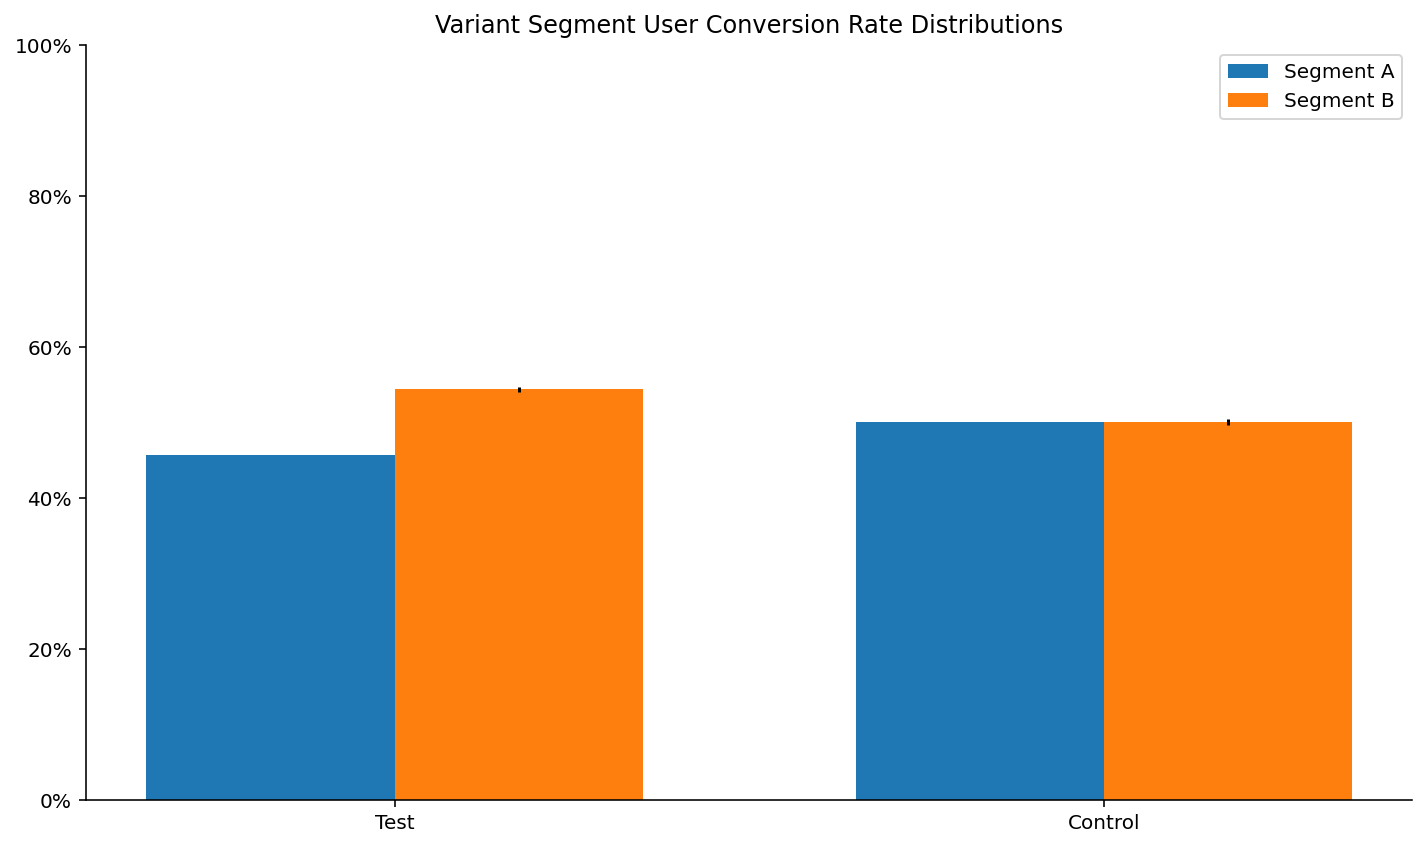

In [13]:
# Set up plots
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
xs = np.array([0, 1])
width = .35

# Plot data
ax.bar(xs, height=df_acq_segment['Segment A'] / df_acq_segment['Total'], 
       width=width, label='Segment A')
ax.bar(xs + width, height=df_acq_segment['Segment B']  / df_acq_segment['Total'], 
       width=width, label='Segment B', yerr=[test_std_error, control_std_error])

# Cosmetic adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Variant Segment User Conversion Rate Distributions')
ax.set_xticks(xs + width / 2)
ax.set_xticklabels(['Test', 'Control'])
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show plot
plt.legend()
plt.tight_layout()
plt.show()


A Bayesian approach seems particularly apt here, since the conditional segment distributions are characterized by $p_{B|i}$, probability of a converted user being a Segment B user given a particular variant. We don't know these ahead of time, but our experiment has provided data that we can apply to our prior beliefs about what these parameters might be.

Using the Control as a prior, we can determine the posterior distribution given the data we actually observed. Simulating from this distribution will allow us to make statements about how and to what degree we expect the spend tracker feature to impact the distribution of user conversion. We'll leverage the beta-binomial conjugacy to keep the prior and posterior in the same family of distributions.

### Profitability

**Hypothesis**: The spend tracker helps overall profitability by driving more cumulative spending per member over their lifetime. The lift in profitability can be decomposed into:
- Incremental profitability due to _higher retention per member_.
- Incremental profitability due to _higher avergage monthly spend per member_.

In [9]:
df_perf

,,,Active User Count,Total Purchase Dollars,Spend Tracker Active User Count
Months Since Conversion,Test Group,Segment,,,
0,Control,Segment A,9906,11887200.12,0
1,Control,Segment A,9708,11766096.57,0
2,Control,Segment A,9028,10725264.67,0
3,Control,Segment A,8486,10081368.11,0
4,Control,Segment A,8153,9783600.30,0
...,...,...,...,...,...
14,Test,Segment B,8618,17071598.41,5019
15,Test,Segment B,8672,17178574.49,5079
16,Test,Segment B,8583,17174252.22,5106


### Member Value

From the case study prompt:

> To evaluate value to members, we look at what percentage of our members test the feature and continue to use it through time.
